# Deep Reinforcement Learning and Q-Learning for Stock Prices
Chapter 13 of the book covers the concept of Reinforcement Learning (RL). The goal of Reinforcement Learning is to model an agent who at some _current state_ of the world, takes an _action_ which then moves it into _next state_ and for taking that action, it receives a _reward_. So, the goal of RL is to learn a policy, _Q_ such that _Q(s, a)_ = _r_. We are also taught that _r_ itself is not just a function of the current state (that would be Markovian as we learned about in Chapter 6), but in actuality _r_ is a function of all prior states and actions. So, _r_ is actually equal to _r(s, a)_, so the reward changes based on what state and action you are actually in.

We learn about _policy_ which is the goal of RL. Given a state you are in, a policy suggests what action to take next. The chapter discusses that Q is not just the immediate reward, and the goal is to learn Q such that it is a _utility_ or assessment of the long-term implications of taking a particular action in a state, not just the immediate reward for that.

Written formally the utility or policy we want to learn can be shown as:
![ch13-q-func](../figs/ch13-q-function.png)

gamma (γ) is a _discount factor_ or a hyperparameter that suggests how much to count the long term reward versus the current state. If γ is small or 0, then we only worry about the current state and not the long term reward.

The first thing we play with is a random choice policy that simply randomly picks between a set of actions. The way that we experiment with RL and eventually RL with Tensorflow (the second example) is via stock prices. The book shows some code that allows us to download stock prices (at 'Open') from a stock given a ticker symbol. In this case we are using 'MSFT' for Microsoft. We download 20 years of stock prices. I had to fix the code in the book since the library they used was old and didn't work anymore. After plotting stock prices, we build an RL agent, and a simple Random policy to pick an action, 'Buy', 'Sell' or 'Hold'. The Random agent doesn't do much to improve wealth regularly. Wealth is measured as the current number of stocks owned, and a budget that we achieve by buying (budget - current stock price we bought it at and num stocks++), selling (budget + current stock price and num stocks--), or holding (doing nothing). 

We also set up a simulation to perform the action N times (N=10), so that we can a simulated RL agent over many tries. The next thing we do is set up a Deep Neural Net with 2 hidden layers to model learning the Q function (also called *Q-learning*). The input vector is a (num stocks, budget, and a 3-stock-hist window) creating a 5 dimensional input. We use a 20-dimensional hidden layer 1, and a 3 dimensional 2nd hidden layer to learn the probability of the 3 actions that we should take at any point in time, given the history of actions taken. The network looks like this:


![ch13-q-network](../figs/ch13-network.png)

Interestingly enough, the agent does learn an optimal policy. It took me a while to figure out that the Weights (W1, W2) and Biases (B1 and B2, a (20,) and (3,) vector of 0.1 a const) and what they were representing. The first hidden layer (h1) represents a 20 neuron understanding of the history, and the second layer (q) represents a mapping of that history to the appropriate summed and multiplied maximized reward (given gamma) over time. A new hyper parameter epsilon ε is introduced in the DeepRL agent to make sure it chooses the optimal choice with probability ε (set to 0.95) and explores 0.05 of the time in our example. The interesting part is that exploration happens more frequently in the first 1000 time steps, then levels out after that. 

Overall an interesting chapter. I didn't really research other references, but I'm sure there are plenty. The book cites Google's Alpha-Go Deep RL work, and also there is work going on at JPL in Deep RL to learn an optimal way to schedule the Deep Space Network (DSN).


In [1]:
# changed to yfinance
import yfinance as yf
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import random
import pandas_datareader.data as web
import pandas as pd

In [2]:
def get_prices(share_symbol, start_date, end_date,
               cache_filename='../data/cache/stock_prices.npy', force=False):
    try:
        if force:
            raise IOError
        else:
            stock_prices = np.load(cache_filename)
    except IOError:
        #share = Share(share_symbol)
        #stock_hist = ystockquote.get_historical_prices(share_symbol, start_date, end_date)
        stock_hist = yf.download(share_symbol, start=start_date, end=end_date)
        #stock_hist = share.get_historical(start_date, end_date)
        stock_prices = []
        stock_hist = stock_hist.sort_values(by=['Date'])
        for index, day in stock_hist.iterrows():
            stock_val = day['Open'].astype(float)
            stock_prices.append(stock_val)
            
        stock_prices = np.asarray(stock_prices)
        #stock_prices = [stock_price['Open'] for stock_price in stock_hist]
        np.save(cache_filename, stock_prices)
        
    return stock_prices.astype(float)

In [3]:
def plot_prices(prices):
    plt.title('Opening stock prices')
    plt.xlabel('day')
    plt.ylabel('price ($)')
    plt.plot(prices)
    plt.savefig('../data/prices.png')
    plt.show()

In [4]:
class DecisionPolicy:
    '''
    Given a state, the decision policy will calculate the next action to take.
    '''
    def select_action(self, current_state, step):
        pass

    '''
    Improve the Q-function from a new experience of taking an action.
    '''
    def update_q(self, state, action, reward, next_state):
        pass

In [5]:
class RandomDecisionPolicy(DecisionPolicy):
    def __init__(self, actions):
        self.actions = actions
    def select_action(self, current_state, step):
        action = random.choice(self.actions)
        return action

In [6]:
class QLearningDecisionPolicy(DecisionPolicy):
    def __init__(self, actions, input_dim):
        self.epsilon = 0.95
        self.gamma = 0.3
        self.actions = actions
        output_dim = len(actions)
        h1_dim = 20

        self.x = tf.placeholder(tf.float32, [None, input_dim])
        self.y = tf.placeholder(tf.float32, [output_dim])
        W1 = tf.Variable(tf.random_normal([input_dim, h1_dim]))
        b1 = tf.Variable(tf.constant(0.1, shape=[h1_dim]))
        self.h1 = tf.nn.relu(tf.matmul(self.x, W1) + b1)
        W2 = tf.Variable(tf.random_normal([h1_dim, output_dim]))
        b2 = tf.Variable(tf.constant(0.1, shape=[output_dim]))
        self.q = tf.nn.relu(tf.matmul(self.h1, W2) + b2)
       
        loss = tf.square(self.y - self.q)
        self.train_op = tf.train.AdagradOptimizer(0.01).minimize(loss)
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
    def select_action(self, current_state, step):
        threshold = min(self.epsilon, step / 1000.)
        if random.random() < threshold:
            action_q_vals = self.sess.run(self.q, feed_dict={self.x:current_state})
            #print(np.shape(action_q_vals))
            #print(self.sess.run(tf.shape(self.h1),feed_dict={self.x:current_state}))
            #print(self.sess.run(tf.shape(self.x), feed_dict={self.x:current_state}))
            #print(current_state)
            action_idx = np.argmax(action_q_vals)
            action = self.actions[action_idx]
        else:
            action = self.actions[random.randint(0, len(self.actions) - 1)]
        return action

    def update_q(self, state, action, reward, next_state):
        action_q_vals = self.sess.run(self.q, feed_dict={self.x: state})
        next_action_q_vals = self.sess.run(self.q, feed_dict={self.x:next_state})
        next_action_idx = np.argmax(next_action_q_vals)
        current_action_idx = self.actions.index(action)
        action_q_vals[0, current_action_idx] = reward + self.gamma * next_action_q_vals[0, next_action_idx]
        action_q_vals = np.squeeze(np.asarray(action_q_vals))
        self.sess.run(self.train_op, feed_dict={self.x: state, self.y:action_q_vals})

In [7]:
def run_simulation(policy, initial_budget, initial_num_stocks, prices, hist):
    budget = initial_budget # The state is a hist + 2 dimensional vector. You’ll force it to be a NumPy matrix.
    # Calculates the portfolio value
    num_stocks = initial_num_stocks
    share_value = 0
    transitions = list()
    for i in range(len(prices) - hist - 1):
        # Initializes values that depend on computing the net worth of a portfolio
        if i % 1000 == 0:
            print('progress {:.2f}%'.format(float(100*i) / (len(prices) - hist - 1)))
        current_state = np.asmatrix(np.hstack((prices[i:i+hist], budget, num_stocks)))
        current_portfolio = budget + num_stocks * share_value
        action = policy.select_action(current_state, i)
        share_value = float(prices[i + hist])
        
        if action == 'Buy' and budget >= share_value:
            budget -= share_value
            num_stocks += 1
        elif action == 'Sell' and num_stocks > 0:
            budget += share_value
            num_stocks -= 1
        else:
            action = 'Hold'

        # Updates portfolio values based on action
        new_portfolio = budget + num_stocks * share_value
        reward = new_portfolio - current_portfolio
        next_state = np.asmatrix(np.hstack((prices[i+1:i+hist+1], budget, num_stocks)))
        transitions.append((current_state, action, reward, next_state))

        policy.update_q(current_state, action, reward, next_state)
    
    #print(transitions)
    portfolio = budget + num_stocks * share_value
    return portfolio

In [8]:
def run_simulations(policy, budget, num_stocks, prices, hist):
# Updates the policy after experiencing a new action
 
    num_tries = 20
    final_portfolios = list()
    for i in range(num_tries):
        # Stores the portfolio worth of each run in this array
        # Runs this simulation
        final_portfolio = run_simulation(policy, budget, num_stocks, prices, hist)
        final_portfolios.append(final_portfolio)
        print('Final portfolio: ${}'.format(final_portfolio))
        plt.title('Final Portfolio Value')
        plt.xlabel('Simulation #')
        plt.ylabel('Net worth')
        plt.plot(final_portfolios)
        plt.show()


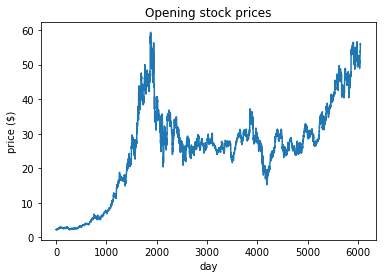

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
progress 0.00%
progress 16.55%
progress 33.10%
progress 49.65%
progress 66.20%
progress 82.75%
progress 99.30%
Final portfolio: $190553.36339187622


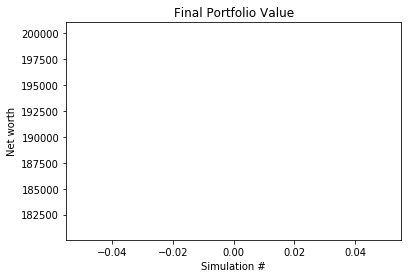

progress 0.00%
progress 16.55%
progress 33.10%
progress 49.65%
progress 66.20%
progress 82.75%
progress 99.30%
Final portfolio: $216900.50475120544


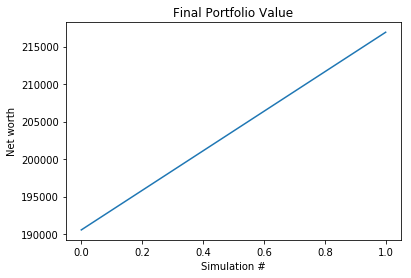

progress 0.00%
progress 16.55%
progress 33.10%
progress 49.65%
progress 66.20%
progress 82.75%
progress 99.30%
Final portfolio: $218849.2363128662


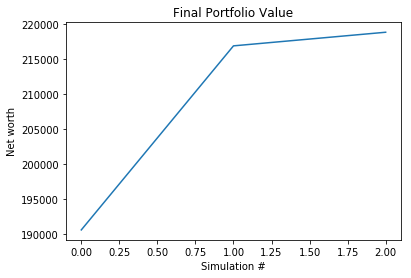

progress 0.00%
progress 16.55%
progress 33.10%
progress 49.65%
progress 66.20%
progress 82.75%
progress 99.30%
Final portfolio: $217076.69991111755


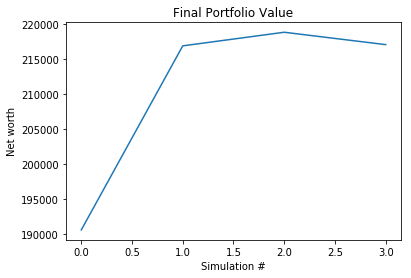

progress 0.00%
progress 16.55%
progress 33.10%
progress 49.65%
progress 66.20%
progress 82.75%
progress 99.30%
Final portfolio: $219040.96428871155


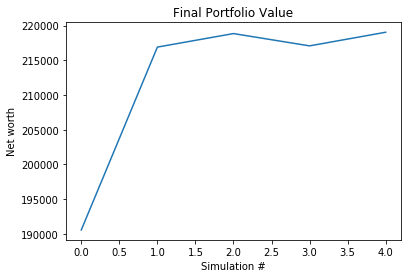

progress 0.00%
progress 16.55%
progress 33.10%
progress 49.65%
progress 66.20%
progress 82.75%
progress 99.30%
Final portfolio: $219175.10244369507


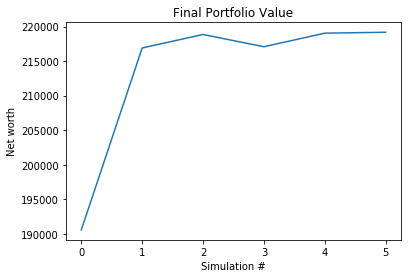

progress 0.00%
progress 16.55%
progress 33.10%
progress 49.65%
progress 66.20%
progress 82.75%
progress 99.30%
Final portfolio: $218890.2331943512


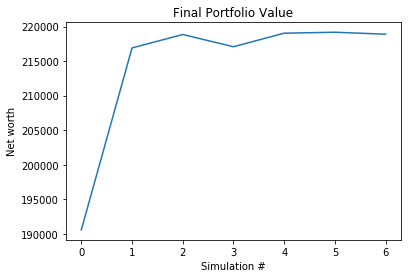

progress 0.00%
progress 16.55%
progress 33.10%
progress 49.65%
progress 66.20%
progress 82.75%
progress 99.30%
Final portfolio: $218559.9771080017


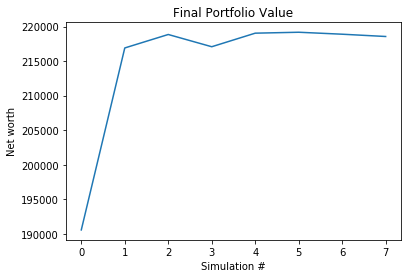

progress 0.00%
progress 16.55%
progress 33.10%
progress 49.65%
progress 66.20%
progress 82.75%
progress 99.30%
Final portfolio: $218197.60116767883


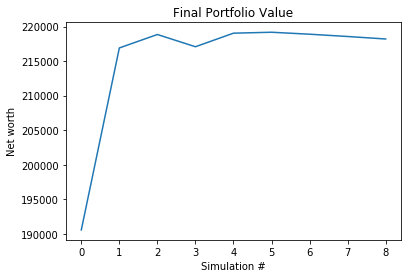

progress 0.00%
progress 16.55%
progress 33.10%
progress 49.65%
progress 66.20%
progress 82.75%
progress 99.30%
Final portfolio: $222703.07998085022


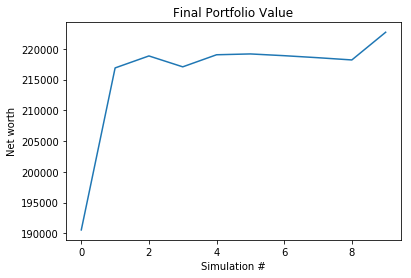

progress 0.00%
progress 16.55%
progress 33.10%
progress 49.65%
progress 66.20%
progress 82.75%
progress 99.30%
Final portfolio: $223066.76983833313


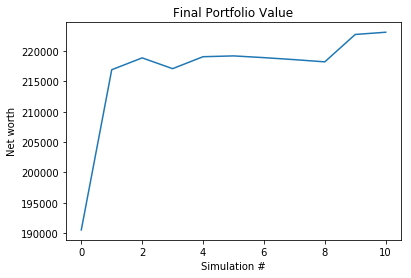

progress 0.00%
progress 16.55%
progress 33.10%
progress 49.65%
progress 66.20%
progress 82.75%
progress 99.30%
Final portfolio: $219104.46321487427


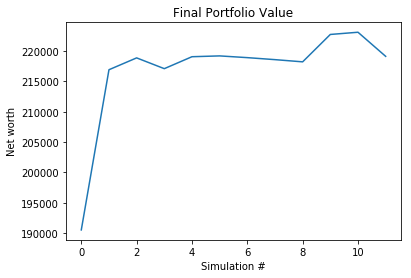

progress 0.00%
progress 16.55%
progress 33.10%
progress 49.65%
progress 66.20%
progress 82.75%
progress 99.30%
Final portfolio: $216346.5372314453


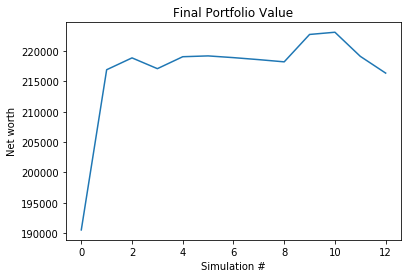

progress 0.00%
progress 16.55%
progress 33.10%
progress 49.65%
progress 66.20%
progress 82.75%
progress 99.30%
Final portfolio: $218499.23084259033


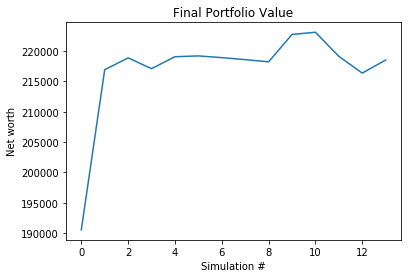

progress 0.00%
progress 16.55%
progress 33.10%
progress 49.65%
progress 66.20%
progress 82.75%
progress 99.30%
Final portfolio: $218526.3625946045


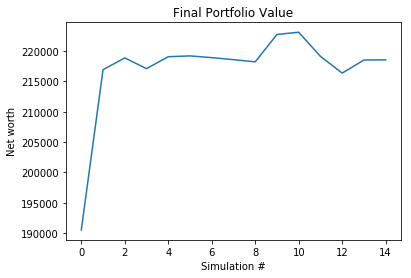

progress 0.00%
progress 16.55%
progress 33.10%
progress 49.65%
progress 66.20%
progress 82.75%
progress 99.30%
Final portfolio: $216764.03082847595


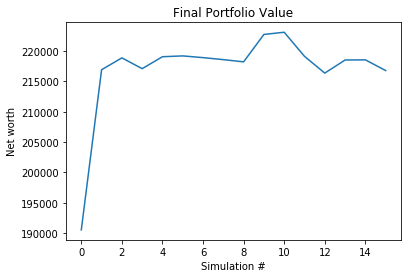

progress 0.00%
progress 16.55%
progress 33.10%
progress 49.65%
progress 66.20%
progress 82.75%
progress 99.30%
Final portfolio: $218910.63256263733


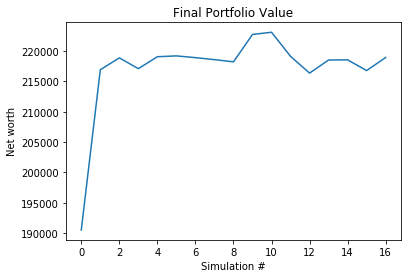

progress 0.00%
progress 16.55%
progress 33.10%
progress 49.65%
progress 66.20%
progress 82.75%
progress 99.30%
Final portfolio: $222369.58412742615


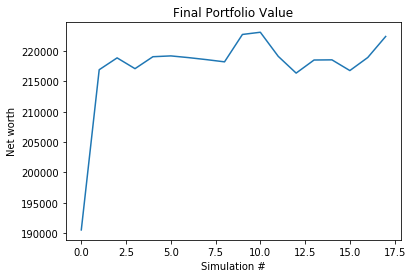

progress 0.00%
progress 16.55%
progress 33.10%
progress 49.65%
progress 66.20%
progress 82.75%
progress 99.30%
Final portfolio: $216870.4320526123


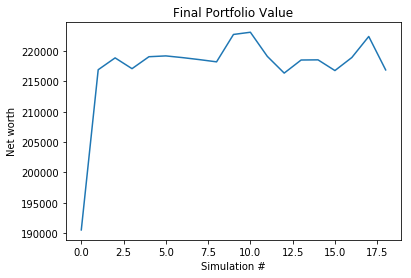

progress 0.00%
progress 16.55%
progress 33.10%
progress 49.65%
progress 66.20%
progress 82.75%
progress 99.30%
Final portfolio: $217246.4067106247


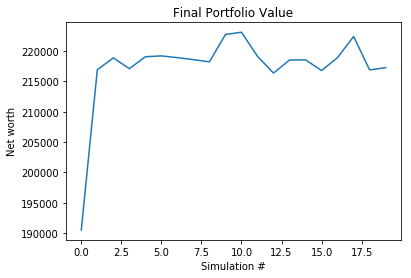

In [9]:
prices = get_prices('MSFT', '1992-07-22', '2016-07-22')
plot_prices(prices)
actions = ['Buy', 'Sell', 'Hold']
hist = 3
policy = QLearningDecisionPolicy(actions, 5) # 5 due to (budget, shares, 3-hist)
budget = 100000.0
num_stocks = 0
run_simulations(policy, budget, num_stocks, prices, hist)